In [40]:
#AlphaVantage API key: ZAPAOIYTE4U33ASM
import requests
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from io import StringIO

api_key = "ZAPAOIYTE4U33ASM"
base_url = "https://www.alphavantage.co/query"

base_currencies = ['USD', 'EUR', 'JPY', 'GBP', 'AUD', 'CAD', 'CHF', 'CNH']
target_currencies_test = ['USD', 'EUR']

def calculate_returns(group):
    group = group.sort_values(by='timestamp', ascending = True)
    group['returns'] = group['close'].pct_change()
    group['returns'].iloc[0] = np.nan
    return group

dfs = []

for base_currency in base_currencies:
    for target_currency in target_currencies_test:
        if base_currency == target_currency:
            continue
        params = {'function': 'FX_DAILY',
                  'from_symbol': base_currency,
                  'to_symbol': target_currency,
                  'outputsize': 'full',
                  'datatype': 'csv',
                  'apikey': api_key}
        response = requests.get(base_url, params=params)
        df = pd.read_csv(StringIO(response.text), header=None, names=['timestamp', 'open', 'high', 'low', 'close'])
        df = df.drop(0).reset_index(drop=True)
        
        df['from_currency'] = base_currency
        df['to_currency'] = target_currency
        df[['open', 'high', 'low', 'close']] = df[['open', 'high', 'low', 'close']].astype(float)
        
        df = df.groupby(['from_currency', 'to_currency']).apply(calculate_returns)
    
        dfs.append(df)
        
df = pd.concat(dfs)
df = df.reset_index(drop=True)

df.head()

,timestamp,open,high,low,close,from_currency,to_currency,returns
0,2014-11-24,0.8081,0.8085,0.8032,0.8036,USD,EUR,NaN
1,2014-11-25,0.8037,0.8059,0.8007,0.8014,USD,EUR,-0.002738
2,2014-11-26,0.8014,0.8034,0.7980,0.7993,USD,EUR,-0.002620
3,2014-11-27,0.7993,0.8024,0.7983,0.8022,USD,EUR,0.003628
4,2014-11-28,0.8023,0.8044,0.8004,0.8028,USD,EUR,0.000748


In [41]:
#Full target currency list (For efficiency purposes implement last)

target_currencies = [
    'AED', 'AFN', 'ALL', 'AMD', 'ANG', 'AOA', 'ARS', 'AUD', 'AWG', 'AZN',
    'BAM', 'BBD', 'BDT', 'BGN', 'BHD', 'BIF', 'BMD', 'BND', 'BOB', 'BRL',
    'BSD', 'BTN', 'BWP', 'BYN', 'BZD', 'CAD', 'CDF', 'CHF', 'CLP', 'CNY',
    'COP', 'CRC', 'CUP', 'CVE', 'CZK', 'DJF', 'DKK', 'DOP', 'DZD', 'EGP',
    'ERN', 'ETB', 'EUR', 'FJD', 'FKP', 'FOK', 'GBP', 'GEL', 'GGP', 'GHS',
    'GIP', 'GMD', 'GNF', 'GTQ', 'GYD', 'HKD', 'HNL', 'HRK', 'HTG', 'HUF',
    'IDR', 'ILS', 'IMP', 'INR', 'IQD', 'IRR', 'ISK', 'JEP', 'JMD', 'JOD',
    'JPY', 'KES', 'KGS', 'KHR', 'KID', 'KMF', 'KRW', 'KWD', 'KYD', 'KZT',
    'LAK', 'LBP', 'LKR', 'LRD', 'LSL', 'LYD', 'MAD', 'MDL', 'MGA', 'MKD',
    'MMK', 'MNT', 'MOP', 'MRU', 'MUR', 'MVR', 'MWK', 'MXN', 'MYR', 'MZN',
    'NAD', 'NGN', 'NIO', 'NOK', 'NPR', 'NZD', 'OMR', 'PAB', 'PEN', 'PGK',
    'PHP', 'PKR', 'PLN', 'PYG', 'QAR', 'RON', 'RSD', 'RUB', 'RWF', 'SAR',
    'SBD', 'SCR', 'SDG', 'SEK', 'SGD', 'SHP', 'SLL', 'SOS', 'SRD', 'SSP',
    'STN', 'SVC', 'SYP', 'SZL', 'THB', 'TJS', 'TMT', 'TND', 'TOP', 'TRY',
    'TTD', 'TVD', 'TWD', 'TZS', 'UAH', 'UGX', 'USD', 'UYU', 'UZS', 'VES',
    'VND', 'VUV', 'WST', 'XAF', 'XCD', 'XOF', 'XPF', 'YER', 'ZAR', 'ZMW', 'ZWL'
]

In [52]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error

In [53]:
def moving_average(df, window):
    return df.rolling(window=window).mean()

def exponential_moving_average(df, window):
    return df.ewm(span=window).mean()

def rate_of_change(df, window):
    return ((df - df.shift(window)) / df.shift(window)) * 100

def relative_strength_index(df, window=14):
    delta = df.diff()
    up, down = delta.copy(), delta.copy()
    up[up < 0] = 0
    down[down > 0] = 0
    avg_gain = up.rolling(window=window).mean()
    avg_loss = down.abs().rolling(window=window).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def bollinger_bands(df, window=20, num_std=2):
    sma = df.rolling(window=window).mean()
    std_dev = df.rolling(window=window).std()
    upper_band = sma + (num_std * std_dev)
    lower_band = sma - (num_std * std_dev)
    return sma, upper_band, lower_band

In [54]:
def create_features(group):
    group['SMA_5'] = moving_average(group['close'], 5)
    group['SMA_10'] = moving_average(group['close'], 10)
    group['EMA_5'] = exponential_moving_average(group['close'], 5)
    group['EMA_10'] = exponential_moving_average(group['close'], 10)
    group['ROC'] = rate_of_change(group['close'], 5)
    group['RSI'] = relative_strength_index(group['close'])
    group['SMA_20'], group['BB_upper'], group['BB_lower'] = bollinger_bands(group['close'])
    group['target'] = group['returns'].shift(-1)  # Shift the returns to predict the next day's return
    return group

df = df.groupby(['from_currency', 'to_currency']).apply(create_features)
df = df.dropna()

In [55]:
#Split Dataset and scale features

X = df[['SMA_5', 'SMA_10', 'EMA_5', 'EMA_10', 'ROC', 'RSI', 'returns', 'SMA_20', 'BB_upper', 'BB_lower']]
y = df['target']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

Random Forest Mean Squared Error: 0.000042


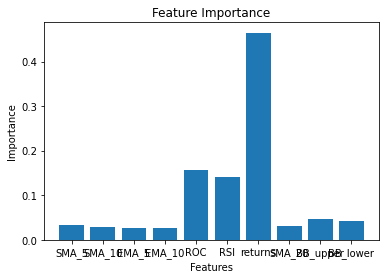

In [63]:
#Random Forest

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

rf_pred = rf_model.predict(X_test)
rf_mse = mean_squared_error(y_test, rf_pred)
print("Random Forest Mean Squared Error: {:.6f}".format(rf_mse))

importance = rf_model.feature_importances_
plt.bar(X.columns, importance)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Feature Importance")
plt.show()

rf_predicted_close = X_test[:, 0] * (1 + rf_pred)

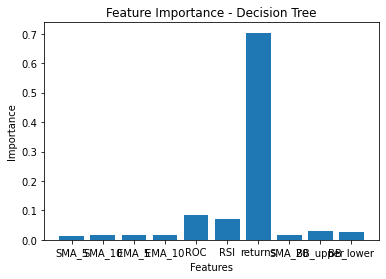

In [64]:
#Decision Tree Model
from sklearn.tree import DecisionTreeRegressor

dt_model = DecisionTreeRegressor(random_state=42)
dt_model.fit(X_train, y_train)
dt_pred = dt_model.predict(X_test)
dt_importance = dt_model.feature_importances_

plt.figure()
plt.bar(X.columns, dt_importance)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Feature Importance - Decision Tree")
plt.show()

dt_predicted_close = X_test[:, 0] * (1 + dt_pred)

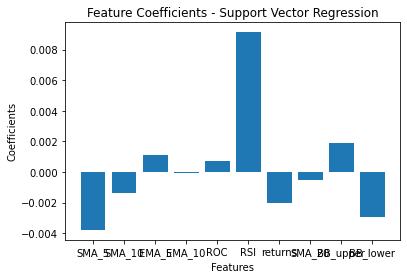

In [60]:
#SVM Model 
from sklearn.svm import SVR

svm_model = SVR(kernel='linear')
svm_model.fit(X_train, y_train)
svm_pred = svm_model.predict(X_test)
svm_coef = svm_model.coef_[0]

plt.figure()
plt.bar(X.columns, svm_coef)
plt.xlabel("Features")
plt.ylabel("Coefficients")
plt.title("Feature Coefficients - Support Vector Regression")
plt.show()

svm_predicted_close = X_test[:, 0] * (1 + svm_pred)

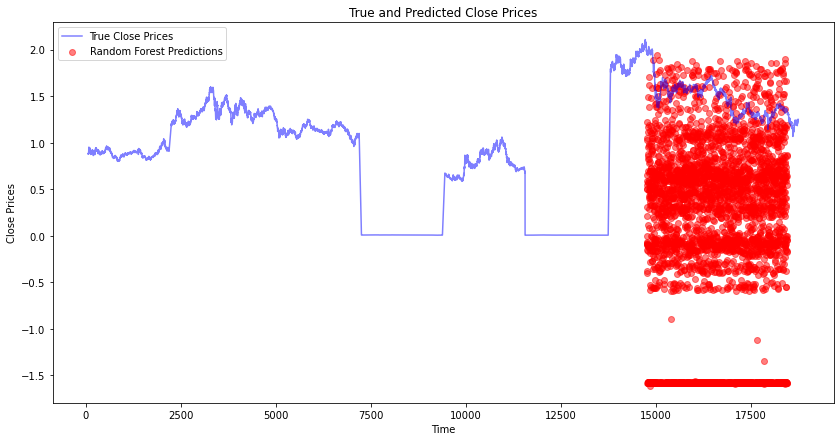

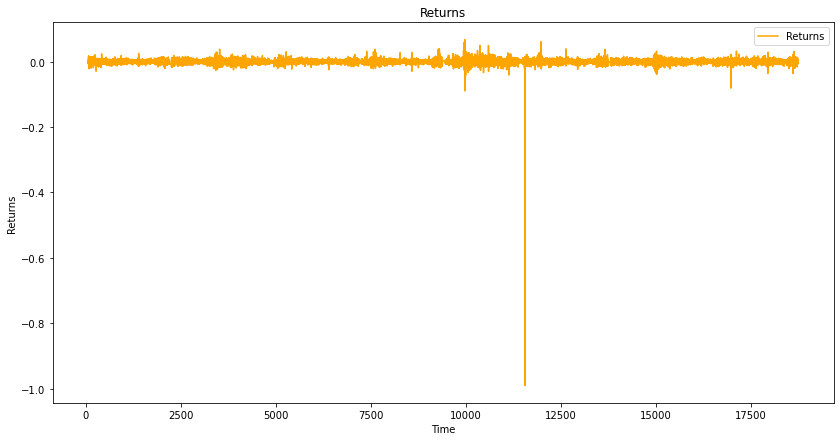

In [66]:
plt.figure(figsize=(14, 7))
plt.plot(df["close"], label="True Close Prices", color="blue", alpha=0.5)

plt.scatter(np.arange(len(X_train), len(X_train) + len(X_test)), rf_predicted_close, label="Random Forest Predictions", color="red", marker="o", alpha=0.5)
#plt.scatter(np.arange(len(X_train), len(X_train) + len(X_test)), dt_predicted_close, label="Decision Tree Predictions", color="green", marker="o", alpha=0.5)
#plt.scatter(np.arange(len(X_train), len(X_train) + len(X_test)), svm_predicted_close, label="SVM Predictions", color="red", marker="o", alpha=0.5)

plt.xlabel("Time")
plt.ylabel("Close Prices")
plt.title("True and Predicted Close Prices")
plt.legend()
plt.show()

plt.figure(figsize=(14, 7))
plt.plot(df["returns"], label="Returns", color="orange")
plt.xlabel("Time")
plt.ylabel("Returns")
plt.title("Returns")
plt.legend()
plt.show()